In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

from config import DATA_DIR

In [2]:
IMAGE_NAME = "317947"
IMAGE_PATH = DATA_DIR.joinpath(f"{IMAGE_NAME}.jpg")

image = cv2.imread(filename=str(IMAGE_PATH))
image = cv2.cvtColor(src=image, code=cv2.COLOR_BGR2RGB)
print(f"Loaded image {IMAGE_PATH} with shape: {image.shape}")

Loaded image C:\Users\punit\projects\research\clotscape\data\317947.jpg with shape: (742, 932, 3)


In [3]:
def display_image(image, title=None, cmap='gray', fig_size=(10, 10)):
    plt.figure(figsize=fig_size)
    plt.imshow(image, cmap=cmap)
    plt.axis('off')
    if title:
        plt.title(title)
    plt.tight_layout()
    plt.show()

def save_image(image, filename):
    if len(image.shape) == 2:  # Grayscale image
        plt.figure()
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(filename, bbox_inches='tight', pad_inches=0, facecolor='white', dpi=300)
        plt.close()
    elif image.shape[2] == 3:  # RGB image
        plt.figure()
        plt.imshow(image)
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(filename, bbox_inches='tight', pad_inches=0, facecolor='white', dpi=300)
        plt.close()
    else:  # BGR image (assuming OpenCV format)
        image = image.astype(np.float32)
        plt.figure()
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(filename, bbox_inches='tight', pad_inches=0, facecolor='white', dpi=300)
        plt.close()

In [4]:
from skimage.restoration import denoise_tv_chambolle, denoise_bilateral, denoise_wavelet


def gaussian_filtering(image, kernel_size=(5, 5), sigma=0):
    return cv2.GaussianBlur(image, kernel_size, sigma)

def median_filtering(image, kernel_size=5):
    return cv2.medianBlur(image, kernel_size)

def non_local_means_denoising(image, h=10, search_window=21, block_size=7):
    return cv2.fastNlMeansDenoisingColored(image, None, h, h, search_window, block_size)

def tv_denoising(image, weight=0.1):
    denoised = denoise_tv_chambolle(image, weight=weight)
    return denoised

def bilateral_denoising(image, win_size=5, sigma_color=0.1, sigma_spatial=15):
    denoised = denoise_bilateral(image, win_size=win_size, sigma_color=sigma_color, sigma_spatial=sigma_spatial, channel_axis=2)
    return denoised

def wavelet_denoising(image):
    denoised = denoise_wavelet(image, method="BayesShrink", mode="soft", rescale_sigma=True)
    return denoised

In [5]:
from skimage.exposure import equalize_adapthist

def intensity_windowing(image, window_level, window_width):
    window_min = window_level - (window_width // 2)
    window_max = window_level + (window_width // 2)
    image_windowed = np.clip(image, window_min, window_max)
    image_windowed = (image_windowed - window_min) / (window_max - window_min) * 255
    return image_windowed.astype(np.uint8)

def z_score_normalization(image, std: float = 1):
    mean = np.mean(image)
    normalized = (image - mean) / (np.std(image) * std)
    return normalized

def percentile_normalization(image, lower_percentile=5, upper_percentile=95):
    lower_value = np.percentile(image, lower_percentile)
    upper_value = np.percentile(image, upper_percentile)
    normalized = (image - lower_value) / (upper_value - lower_value)
    normalized = np.clip(normalized, 0, 1)
    return normalized

def clahe_normalization(image, kernel_size=None, clip_limit=0.01, nbins=256):
    normalized = equalize_adapthist(image, kernel_size=kernel_size, clip_limit=clip_limit, nbins=nbins)
    return normalized

In [6]:
from skimage import color, filters, feature

def canny_edge_detection(image, sigma=1, low_threshold=0.1, high_threshold=0.2):
    # Convert the image to grayscale if it's not already
    if image.ndim == 3:
        image = color.rgb2gray(image)

    # Compute the Canny edges
    edges = feature.canny(image=image, low_threshold=low_threshold, high_threshold=high_threshold)

    return edges

def sobel_edge_detection(image, ksize:int = 3):
    # Convert image to float32 to prevent overflow/underflow issues
    image = image.astype(np.float32)

    # Compute gradients along the x and y axes
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=ksize)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=ksize)

    # Calculate the gradient magnitude and normalize the result
    sobel = np.sqrt(sobelx**2 + sobely**2)
    sobel = cv2.normalize(sobel, None, 0, 255, cv2.NORM_MINMAX)
    return sobel.astype(np.uint8)

def log_edge_detection(image, sigma=2):
    log_edges = filters.laplace(filters.gaussian(image, sigma=sigma))
    log_edges = (log_edges - log_edges.min()) / (log_edges.max() - log_edges.min()) * 255
    return log_edges.astype(np.uint8)


def scharr_edge_detection(image):
    # Convert image to float32 to prevent overflow/underflow issues
    image = image.astype(np.float32)

    # Compute gradients along the x and y axes
    scharrx = cv2.Scharr(image, cv2.CV_32F, 1, 0)
    scharry = cv2.Scharr(image, cv2.CV_32F, 0, 1)

    # Calculate the gradient magnitude and normalize the result
    scharr = np.sqrt(scharrx**2 + scharry**2)
    scharr = cv2.normalize(scharr, None, 0, 255, cv2.NORM_MINMAX)
    return scharr.astype(np.uint8)

## Pipeline

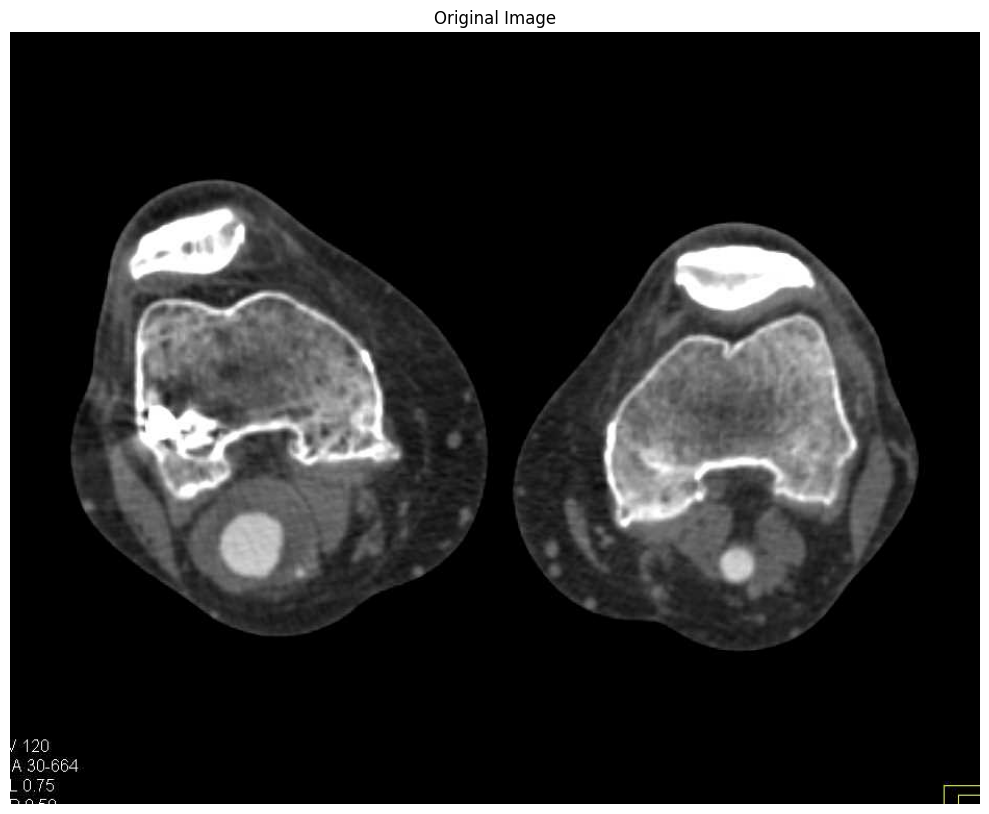

In [7]:
display_image(image, title="Original Image")

In [8]:
PIPELINE_DIR = DATA_DIR.joinpath("pipeline")
PIPELINE_DIR.mkdir(exist_ok=True)

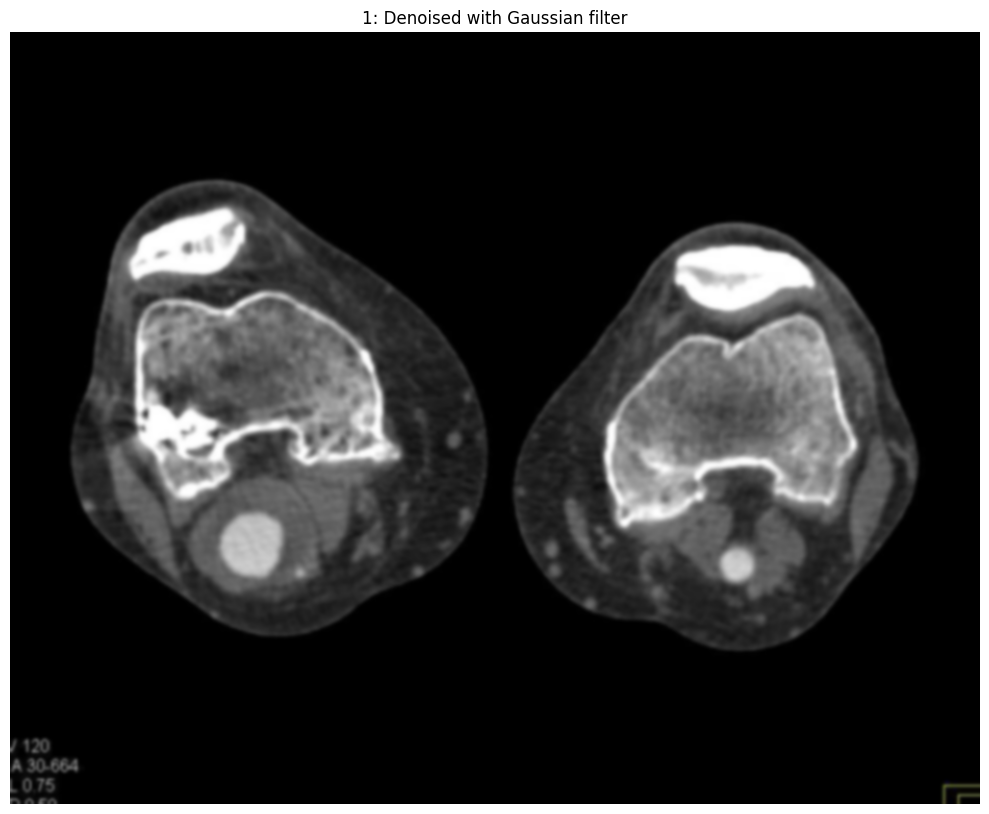

In [9]:
# Denoising with Gaussian filter
denoised_gaussian = gaussian_filtering(image, kernel_size=(9, 9), sigma=1.5)
display_image(denoised_gaussian, title="1: Denoised with Gaussian filter")
save_image(denoised_gaussian, str(PIPELINE_DIR.joinpath(f"{IMAGE_NAME}_1_denoised_gaussian.jpg")))

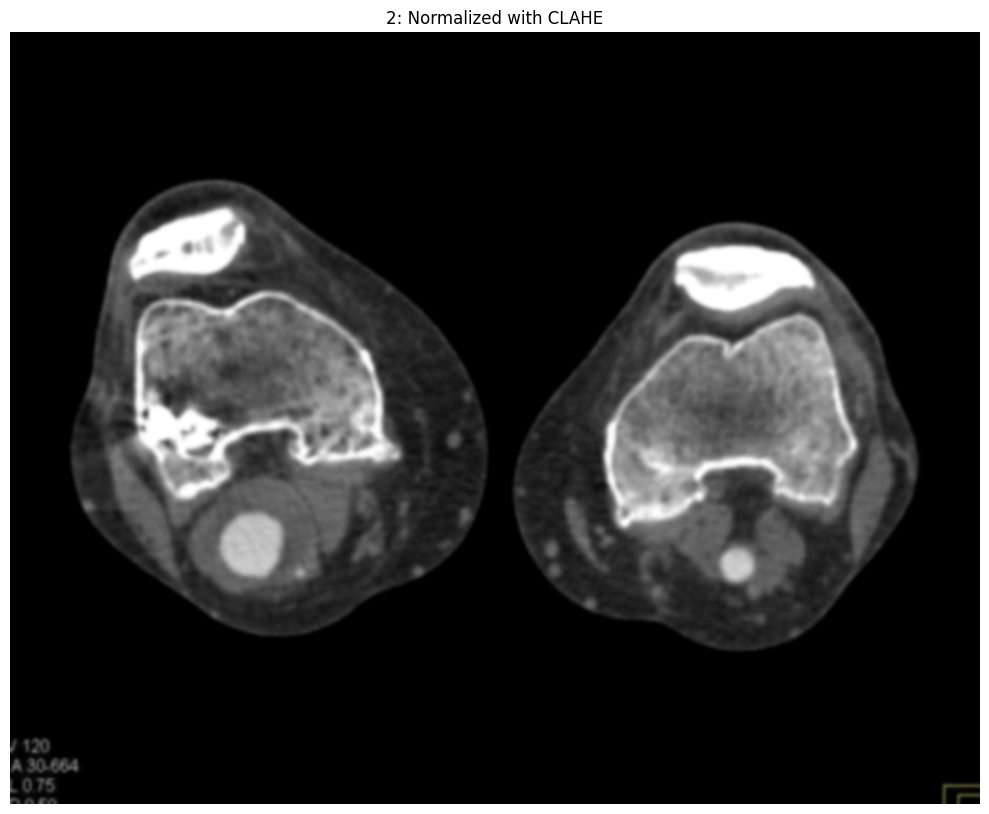

In [18]:
# Contrast Limited Adaptive Histogram Equalization (CLAHE) normalization
normalized_clahe = clahe_normalization(denoised_gaussian, kernel_size=(8, 8), clip_limit=0.01, nbins=64)
display_image(normalized_clahe, title="2: Normalized with CLAHE")
save_image(normalized_clahe, str(PIPELINE_DIR.joinpath(f"{IMAGE_NAME}_2_normalized_clahe.jpg")))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


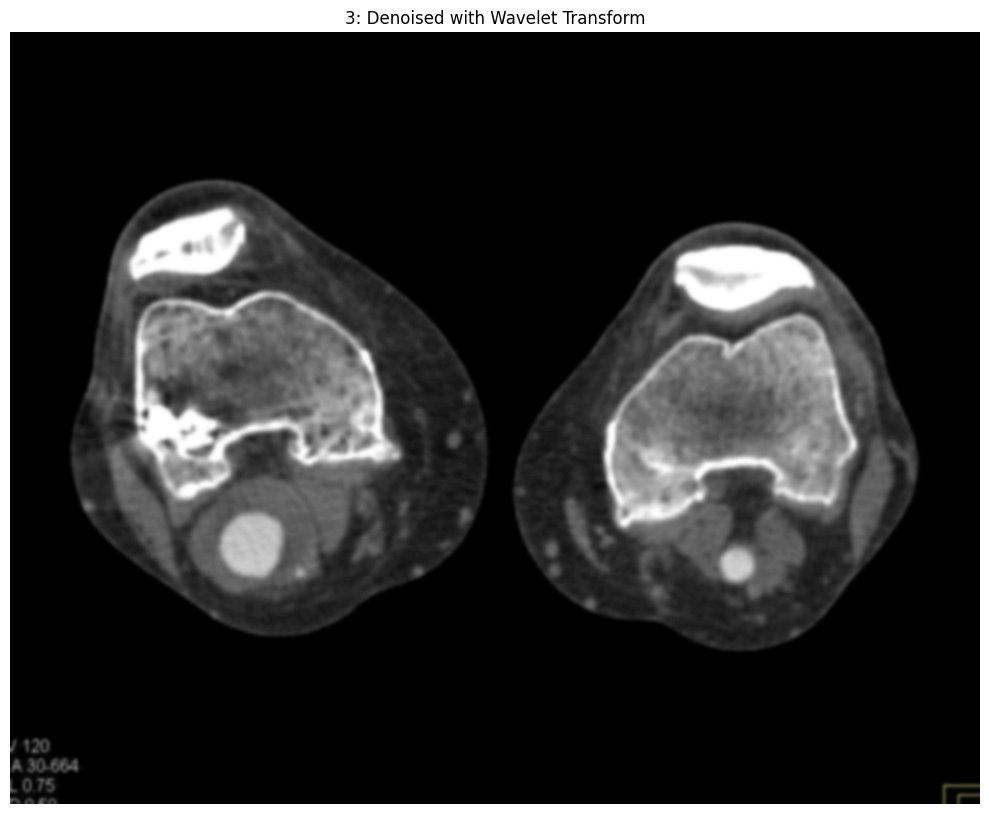

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [11]:
# Denoising with Wavelet Transform
denoised_wavelet = wavelet_denoising(normalized_clahe)
display_image(denoised_wavelet, title="3: Denoised with Wavelet Transform")
save_image(denoised_wavelet, str(PIPELINE_DIR.joinpath(f"{IMAGE_NAME}_3_denoised_wavelet.jpg")))

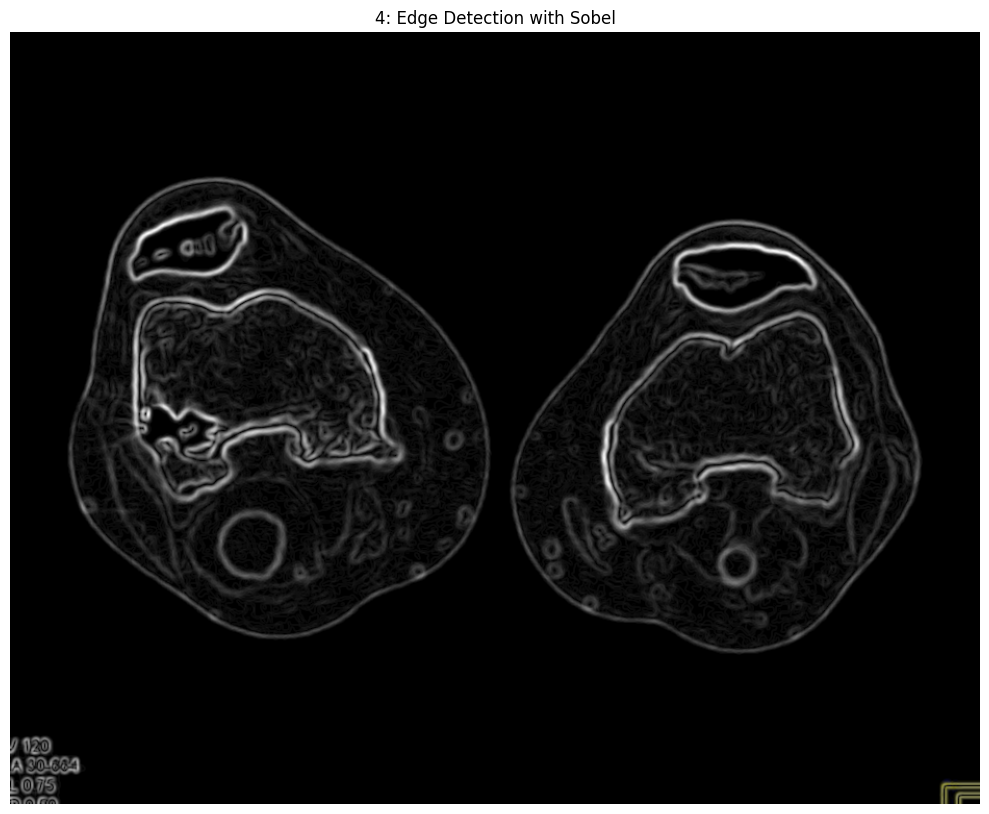

In [12]:
# Edge detection with Sobel
edges_sobel = sobel_edge_detection(denoised_gaussian, ksize=3)

display_image(edges_sobel, title="4: Edge Detection with Sobel")
save_image(edges_sobel, str(PIPELINE_DIR.joinpath(f"{IMAGE_NAME}_4_edges_sobel.jpg")))

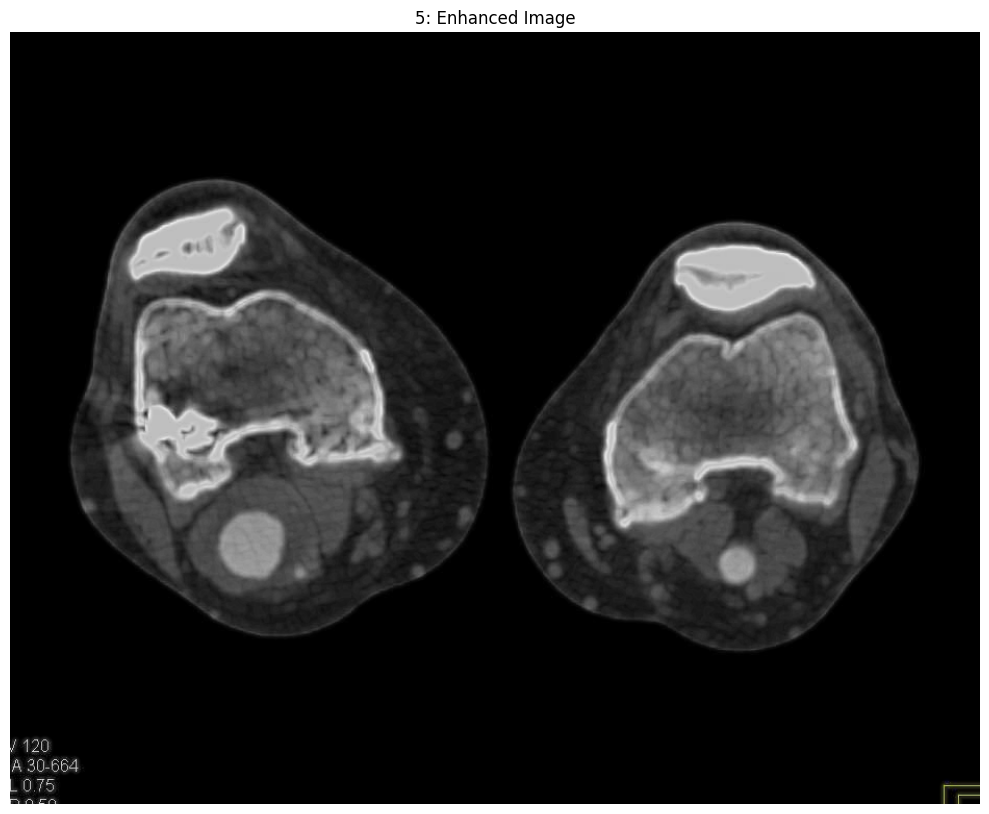

In [29]:
# Combine with the original image
# edges_sobel_rgb = cv2.cvtColor(edges_sobel, cv2.COLOR_GRAY2RGB)
overlay_sobel = cv2.addWeighted(src1=image, alpha=0.75, src2=edges_sobel, beta=0.25, gamma=0)

display_image(overlay_sobel, title="5: Enhanced Image")
save_image(overlay_sobel, str(PIPELINE_DIR.joinpath(f"{IMAGE_NAME}_5_enhanced_image.jpg")))

In [13]:
from PIL import Image
import cv2
import numpy as np

# Define a function to apply cv2.addWeighted with varying alpha, beta, or gamma values
def create_image_sequence(original_image, parameter, values):
    images = []
    for value in values:
        if parameter == 'alpha':
            new_image = cv2.addWeighted(src1=original_image, alpha=value, src2=edges_sobel, beta=0.5, gamma=0.15)
        elif parameter == 'beta':
            new_image = cv2.addWeighted(src1=original_image, alpha=0.5, src2=edges_sobel, beta=value, gamma=0.15)
        elif parameter == 'gamma':
            new_image = cv2.addWeighted(src1=original_image, alpha=0.5, src2=edges_sobel, beta=0.5, gamma=value)

        # Add title to the image
        cv2.putText(new_image, f"{parameter}: {value:.2f}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        images.append(Image.fromarray(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)))
    return images

# Generate a sequence of images for each parameter
alpha_values = np.linspace(0, 1, 30)  # 30 frames for 3 seconds
beta_values = np.linspace(0, 1, 30)
gamma_values = np.linspace(0, 1, 30)

alpha_images = create_image_sequence(image, 'alpha', alpha_values)
beta_images = create_image_sequence(image, 'beta', beta_values)
gamma_images = create_image_sequence(image, 'gamma', gamma_values)

# Save each sequence of images as a GIF
alpha_images[0].save('alpha_animation.gif', save_all=True, append_images=alpha_images[1:], optimize=False, duration=100, loop=0)
beta_images[0].save('beta_animation.gif', save_all=True, append_images=beta_images[1:], optimize=False, duration=100, loop=0)
gamma_images[0].save('gamma_animation.gif', save_all=True, append_images=gamma_images[1:], optimize=False, duration=100, loop=0)

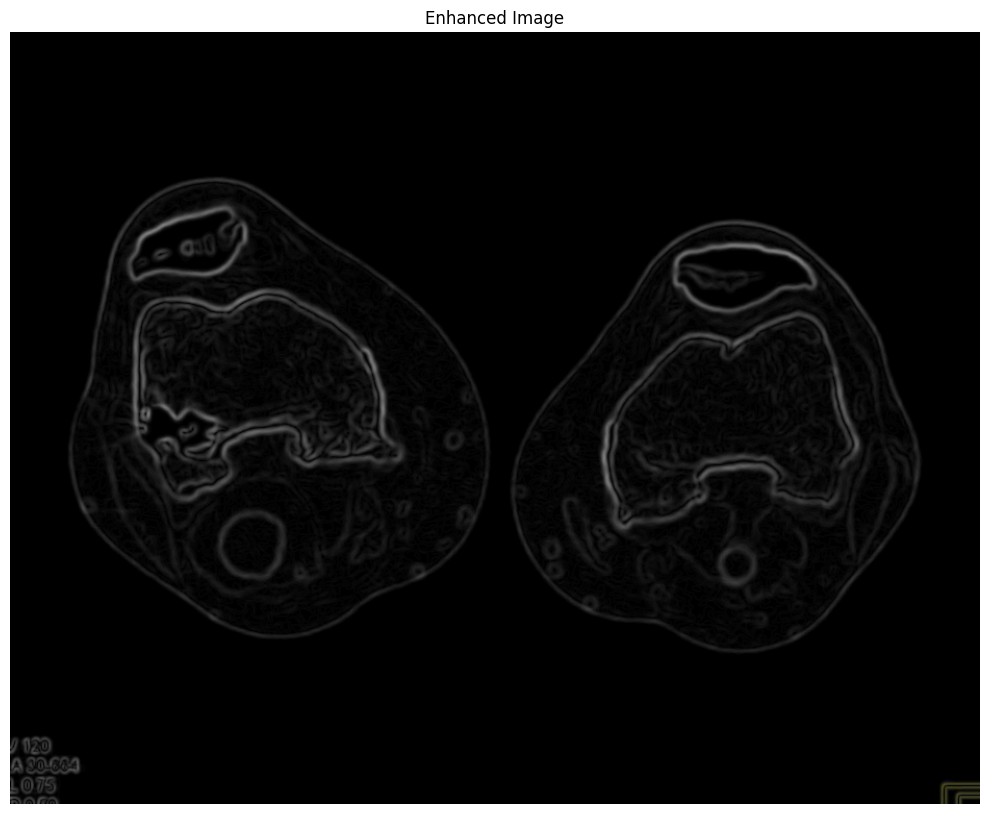

In [22]:
# Convert images to float32 data type
filtered_image_float = normalized_clahe.astype(np.float32)
edges_sobel_float = edges_sobel.astype(np.float32)

enhanced_image = cv2.addWeighted(src1=filtered_image_float, alpha=0.5, src2=edges_sobel_float, beta=0.5, gamma=0)

# Convert the enhanced image back to uint8 for display and saving
enhanced_image_uint8 = np.clip(enhanced_image, 0, 255).astype(np.uint8)

display_image(enhanced_image_uint8, title="Enhanced Image")
save_image(enhanced_image_uint8, str(PIPELINE_DIR.joinpath(f"{IMAGE_NAME}_enhanced.jpg")))

In [21]:
def create_image_sequence(denoised_wavelet, parameter, values):
    images = []
    for value in values:
        # Convert images to float32 data type
        denoised_wavelet_float = denoised_wavelet.astype(np.float32)
        edges_sobel_float = edges_sobel.astype(np.float32)

        if parameter == 'alpha':
            new_image = cv2.addWeighted(src1=denoised_wavelet_float, alpha=value, src2=edges_sobel_float, beta=0.5, gamma=0.15)
        elif parameter == 'beta':
            new_image = cv2.addWeighted(src1=denoised_wavelet_float, alpha=0.5, src2=edges_sobel_float, beta=value, gamma=0.15)
        elif parameter == 'gamma':
            new_image = cv2.addWeighted(src1=denoised_wavelet_float, alpha=0.5, src2=edges_sobel_float, beta=0.5, gamma=value)

        # Convert the new image back to uint8 for display and saving
        new_image_uint8 = np.clip(new_image, 0, 255).astype(np.uint8)

        cv2.putText(new_image_uint8, f"{parameter}: {value:.2f}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        images.append(Image.fromarray(cv2.cvtColor(new_image_uint8, cv2.COLOR_BGR2RGB)))
    return images

# Generate a sequence of images for each parameter
alpha_values = np.linspace(0, 1, 30)  # 30 frames for 3 seconds
beta_values = np.linspace(0, 1, 30)
gamma_values = np.linspace(0, 1, 30)

alpha_images = create_image_sequence(denoised_wavelet, 'alpha', alpha_values)
beta_images = create_image_sequence(denoised_wavelet, 'beta', beta_values)
gamma_images = create_image_sequence(denoised_wavelet, 'gamma', gamma_values)

# Save each sequence of images as a GIF
alpha_images[0].save('enhanced_alpha_animation.gif', save_all=True, append_images=alpha_images[1:], optimize=False, duration=100, loop=0)
beta_images[0].save('enhanced_beta_animation.gif', save_all=True, append_images=beta_images[1:], optimize=False, duration=100, loop=0)
gamma_images[0].save('enhanced_gamma_animation.gif', save_all=True, append_images=gamma_images[1:], optimize=False, duration=100, loop=0)